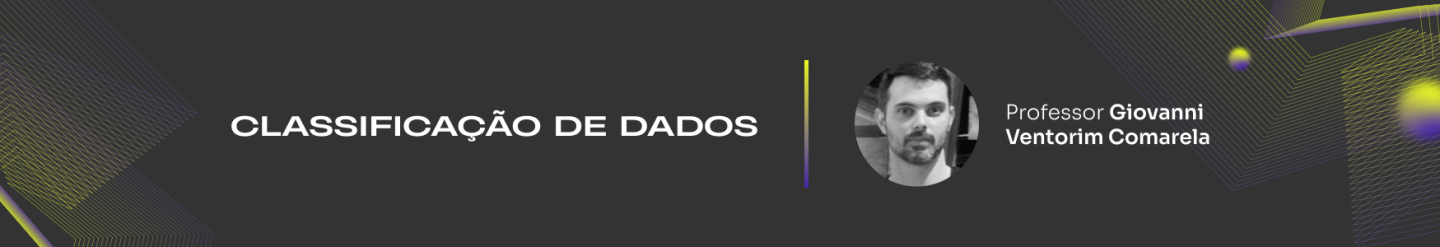

#*Support Vector Machine* (SVM) - Parte I

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

**Observação 1:** No contexto de SVM, vamos assumir que $y_i \in \{-1, 1\}$.

**Observação 2:** O SVM é um pouco mais complicado que os classificadores que vimos até o momento. Um tratamento completo e formal foge ao escopo dessa aula.

## SVM - Motivação

Considere o conjunto de dados abaixo. Cada instância possui duas características, $u_1$ e $u_2$, e um rótulo, $y$.

O conjunto de dados é também apresentado pela figura seguinte.

In [ ]:
#@title

import numpy as np
import pandas as pd

df = pd.DataFrame([[3.5, 4.25, 1],
     [4, 3, 1],
     [4, 4, 1],
     [4.5, 1.75, 1],
     [4.9, 4.5, 1],
     [5, 4, 1],
     [5.5, 2.5, 1],
     [5.5, 3.5, 1],
     [0.5, 1.5, -1],
     [1, 2.5, -1],
     [1.25, 0.5, -1],
     [1.5, 1.5, -1],
     [2, 2, -1],
     [2.5, 0.75, -1]], columns = 'u1 u2 y'.split())

df

,u1,u2,y
0,3.50,4.25,1
1,4.00,3.00,1
2,4.00,4.00,1
3,4.50,1.75,1
4,4.90,4.50,1
5,5.00,4.00,1
6,5.50,2.50,1
7,5.50,3.50,1
8,0.50,1.50,-1
9,1.00,2.50,-1


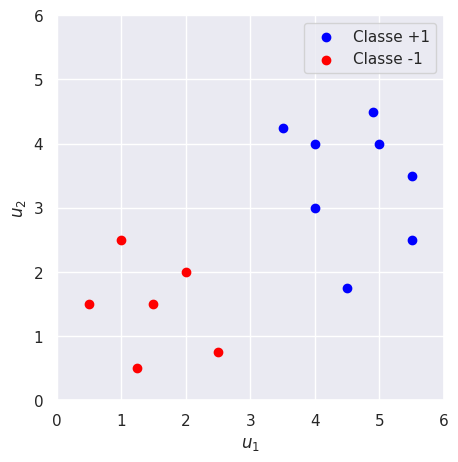

In [ ]:
#@title

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig = plt.figure(figsize = (5, 5))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Classe +1')
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Classe -1')
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.legend(loc = 'best');

plt.xlim((0, 6))
plt.ylim((0, 6));

Perguntas:
1. É possível separar os pontos de classes distintas com uma reta (função linear)?
2. Se sim, qual a melhor reta?

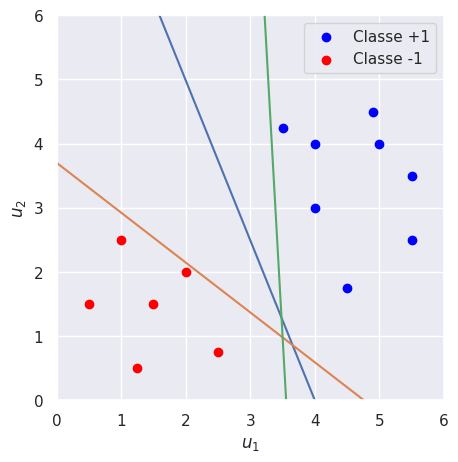

In [ ]:
#@title

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 5))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Classe +1')
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Classe -1')
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.legend(loc = 'best');

x0 = np.array([0, 5])
y0 = -(1 / 0.334) * (0.833 * x0 - 3.332)
plt.plot(x0, y0)

y1 = -(1 / 0.9) * (0.7 * x0 - 3.332)
plt.plot(x0, y1)

y2 = -(1 / 0.05) * (0.9 * x0 - 3.2)
plt.plot(x0, y2)

plt.xlim((0, 6))
plt.ylim((0, 6));

Pode-se perceber que a linha de cor azul está equidistante das duas nuvens de pontos. Assim, parece mais adequada para realizar a separação.

Na aula de hoje, vamos construir um algoritmo que é capaz de encontrar essa linha no caso geral (qualquer dimensão).

## Problema de hoje

**Entrada:**
- um conjunto de pontos rotulados (problema de classificação binária) **que pode ser separado** por uma função linear

**Objetivo:**
- Encontrar a "melhor" função linear de separação.

## Preliminares

Para resolver o problema proposto, precisamos relembrar vários conceitos relacionados à **geometria analítica**.

### Hiperplano

Um hiperplano no espaço $d$-dimensional é um conjunto de pontos $\mathbf{x} \in \mathbb{R}^d$ que satisfazem a equação $h(\mathbf{x}) = 0$, onde

$$h(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b = w_1x_1, + w_2x_2+\dots + w_dx_d + b.$$

Aqui, $\mathbf{w}$ é o vetor de pesos (ou coeficientes) e $b$ é um escalar (*bias*).

**Observações (casos especiais):**
- Quando $d = 2$, um hiperplano é uma reta (equação $ax_1 + bx_2 + c = 0$);

- Quando $d = 3$, um hiperplano é um plano (equação $ax_1 + bx_2 + cx_3 + d = 0)$.


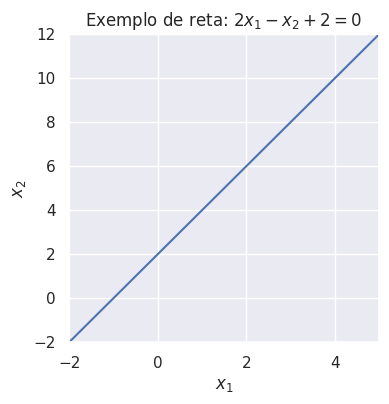

In [ ]:
#@title Exemplo de Reta
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (4, 4))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

x0 = np.array([-2, 5])
y0 = 2 * x0 + 2
plt.plot(x0, y0);

plt.xlim((-2, 5))
plt.ylim((-2, 12));

plt.title(r'Exemplo de reta: $2x_1 - x_2 + 2 = 0$');

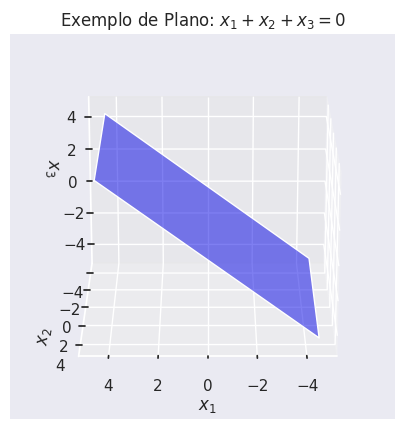

In [ ]:
#@title Exemplo de Plano
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection='3d')

u = np.array([1, 0, 1])
v = np.array([0, 1, 0])
u = u / np.linalg.norm(u, ord = 2)
v = v / np.linalg.norm(v, ord = 2)

def plotPlane3d(u, v, length, plotter, color = 'blue'):
    normal = np.cross(u, v)
    a, b, c = normal
    x, y = np.meshgrid(np.array([-1, 1]) * (length / 2.0), np.array([-1, 1]) * (length / 2.0))
    z = (-a * x - b * y) / c
    plotter.plot_surface(x, y, z, alpha = 0.5, color = color)

plotPlane3d(u, v, 9, ax)

# plotting figure
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.set_zlabel(r'$x_3$');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.set_title(r'Exemplo de Plano: $x_1 + x_2 + x_3 = 0$');

# 5
# rotate the axes and update
ax.view_init(20, 90);
#plt.show()

### Hiperplano de separação

- Um hiperplano separa o espaço $d$-dimensional em duas metades
- Um conjunto de dados é dito ser **linearmente separável** se há um hiperplano que separa os pontos das duas classes de forma pura.
>- Em outras palavras, para todos os pontos $\mathbf{x}$ com $h(\mathbf{x}) < 0$ tem-se rótulo -1; e para todos $\mathbf{x}$'s com $h(\mathbf{x}) > 0$ tem-se rótulo +1.
>- Nesse caso, o plano $h(\mathbf{x})$ pode ser visto como um classificador. Dado um elemento $\mathbf{z}$ a ser classificado, tem-se que o rótulo predito de $\mathbf{z}$ será +1 se $h(\mathbf{z}) > 0$ e -1, caso contrário.

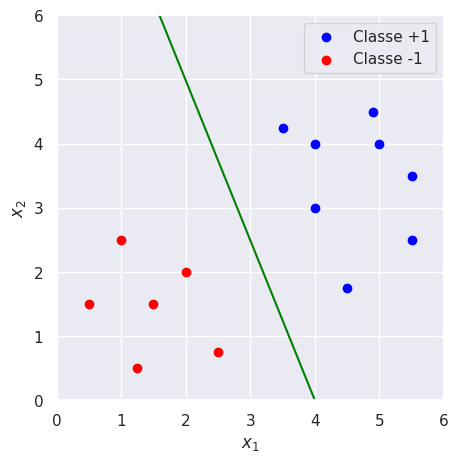

In [ ]:
#@title Exemplo de Conjunto de Dados Linearmente Separável

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5, 5))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Classe +1')
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Classe -1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc = 'best');

x0 = np.array([0, 5])
y0 = -(1 / 0.334) * (0.833 * x0 - 3.332)
plt.plot(x0, y0, color = 'green')


plt.xlim((0, 6))
plt.ylim((0, 6));

### Distância Ponto-Hiperplano

Dados
- um hiperplano definido pelos pontos que satisfazem $h(\mathbf{x}) = 0$, com $h(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$, e
- um ponto $\mathbf{z}$ que não está no hiperplano.

Qual a distância entre o hiperplano e o ponto?

Pode-se mostrar que a distância entre o ponto e o hiperplano é dada por
$$\frac{|h(\mathbf{z})|}{\Vert\mathbf{w}\Vert},$$
onde $\Vert\mathbf{w}\Vert = \sqrt{\sum_{j = 1}^dw_j^2}$ é a norma do vetor $\mathbf{w}$.

Especificamente no caso de um conjunto de dados rotulado e **linearmente separável** (situação de hoje), a distância acima pode ser reescrita como
$$\frac{yh(\mathbf{z})}{\Vert\mathbf{w}\Vert},$$
onde $y$ é o rótulo associado ao ponto $\mathbf{z}$.

Vejam que **interessante:** A distância depende do ponto, do hiperplano e do **rótulo** do ponto.


### Margem e vetores de suporte de um hiperplano

Dados
- um conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$, com $y_i \in \{-1, 1\}$ que seja **linearmente separável**, e
- um hiperplano de separação $h(\mathbf{x}) = 0$ que separe $D$ em duas metades puras,

tem-se que a distância do hiperplano para cada ponto de $D$ é
$$\frac{y_ih(\mathbf{x}_i)}{\Vert\mathbf{w}\Vert} = \frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert}.$$

A **margem** de $h$ com respeito a $D$ é definida por
$$\min_{i}\left\{\frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert}\right\}.$$
Em outras palavras, a margem é a menor distância entre o hiperplano e qualquer ponto do conjunto de dados.

Todos os pontos (ou vetores) que estejam sobre a margem (i.e., tenham distância mínima para o hiperplano) são chamados de **vetores de suporte** do hiperplano.

PS: esses vetores são importantes para o classificador que estamos desenvolvendo. Daí o nome *Support Vector Machine*.

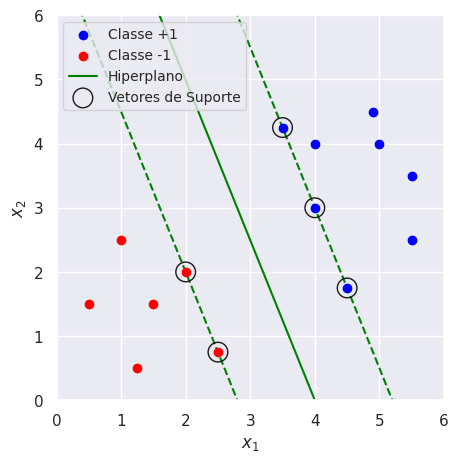

In [ ]:
#@title Ilustração de Hiperplano, Margem e Vetores de Suporte

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_vector(v, color, org = np.array([0, 0]), zorder = 0, alpha = 0.8):
  plt.quiver(org[0], org[1], v[0], v[1],
       color = color,
       zorder = 10, alpha = alpha, width = 0.013, angles='xy', scale_units='xy', scale=1)

fig = plt.figure(figsize = (5, 5))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Classe +1', zorder = 2)
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Classe -1', zorder = 2)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')


x0 = np.array([0, 5])
y0 = -(1 / 0.334) * (0.833 * x0 - 3.332)
plt.plot(x0, y0, color = 'green', label = 'Hiperplano')

xx = df['u1']
yy = df['u2']

m = (yy[1] - yy[0]) / (xx[1] - xx[0])
b = yy[0] - m * xx[0]
x1 = np.array([0, 6])
y1 = m * x1 + b
plt.plot(x1, y1, color = 'green', linestyle = 'dashed', zorder = 1)

m = (yy[13] - yy[12]) / (xx[13] - xx[12])
b = yy[12] - m * xx[12]
x2 = np.array([0, 6])
y2 = m * x1 + b
plt.plot(x2, y2, color = 'green', linestyle = 'dashed', zorder = 1)


plt.scatter([xx[0], xx[1], xx[3], xx[12], xx[13]], [yy[0], yy[1], yy[3], yy[12], yy[13]] , s=200,
           linewidth=1, facecolors='none', edgecolors='k', label = 'Vetores de Suporte')


plt.xlim((0, 6))
plt.ylim((0, 6));

plt.legend(loc = 2, prop={'size': 10});

plt.show();

### Hiperplano Canônico

O mesmo hiperplano pode ser representado por uma infinidade de coeficientes $\mathbf{w}$ e $b$.

Por exemplo, as equações abaixo definem o mesmo conjunto de pontos (hiperplanos):
1. $2x_1 + 3x_2 + 1 = 0$
2. $4x_1 + 6x_2 + 2 = 0$
3. $2\alpha x_1 + 3\alpha x_2 + \alpha = 0$, para todo $\alpha \neq 0$.

Um truque na formulação do SVM é fixar $\mathbf{w}$ e $b$ de uma forma específica. Essa forma específica é denotada por **hiperplano canônico**.

A representação canônica de um hiperplano é tal que a **margem** do hiperplano tenha tamanho $\frac{1}{\Vert\mathbf{w}\Vert}$.:

Ao utilizar a representação canônica, tem-se, para todo $(\mathbf{x}_i, y_i) \in D$ que:
$$
\frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert} \ge \frac{1}{\Vert\mathbf{w}\Vert}.
$$

Na parte da esquerda temos a distância entre cada ponto e o hiperplano. Na parte da direita temos o tamanho da margem (que é o menor valor dessas distâncias).

Como consequência, tem-se, para todo $(\mathbf{x}_i, y_i) \in D$ que:
$$
y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1.
$$

## SVM: Caso linearmente separável

### Formulação

Considere um conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$, com $y_i \in \{-1, 1\}$ que seja **linearmente separável**.

A ideia fundamental do SVM é encontrar a representação canônica de um hiperplano de separação que tenha **margem máxima** entre todos os hiperplanos de separação (que separem $D$ de forma pura).

Assim, nosso problema é transformado no seguinte problema de otimização:

**Função objetivo:**
$$\max_{\mathbf{w}, b} \frac{1}{\Vert\mathbf{w}\Vert}$$

**Restrições:** $y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1$, para $i = 1, \dots, n$.

O problema acima é equivalente ao seguinte problema.

**Função objetivo:**
$$\min_{\mathbf{w}, b} \frac{\Vert\mathbf{w}\Vert^2}{2}$$

**Restrições:** $y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1$, para $i = 1, \dots, n$.

E é esse problema de otimização que, geralmente, é abordado!

### Solução

O problema de otimização acima não possui solução com fórmula fechada.

Em geral, são utilizados algoritmos de otimização numérica para se obter $\mathbf{w}$ e $b$.

Uma vez que essas quantidades são conhecidas, também conhece-se a equação do hiperplano, que, por sua vez, nos dá o classificador.

Na próxima aula, vamos generalizar esse raciocínio para situações que não são 100% linearmente separáveis. Veremos também exemplos na ``scikit-learn``.

## Referências

1. Capítulo 21 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)